In [1]:
import warnings
warnings.filterwarnings('ignore') # 実行に影響のない　warninig　を非表示にします. 非推奨.

# Chapter 5: 機械学習 回帰問題

## 5-1. 回帰問題を Pythonで解いてみよう

1. データセットの用意
2. モデル構築

### 5-1-1. データセットの用意
今回はwine-quality datasetを用いる.  
wine-quality dataset はワインのアルコール濃度や品質などの12要素の数値データ.  
赤ワインと白ワイン両方あります。赤ワインの含まれるデータ数は1600ほど.   
まずはデータセットをダウンロードする.  
proxy下ではjupyter notebookに設定をしないと以下は動作しない.  

In [1]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
! mv winequality-red.csv data/winequality-red.csv

--2021-09-21 22:49:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
archive.ics.uci.edu (archive.ics.uci.edu) をDNSに問いあわせています... 128.195.10.252
archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 84199 (82K) [application/x-httpd-php]
`winequality-red.csv' に保存中

100%[======================================>] 84,199       365KB/s 時間 0.2s     

2021-09-21 22:49:10 (365 KB/s) - `winequality-red.csv' へ保存完了 [84199/84199]



jupyter notebook の設定が面倒な人へ.  
proxyの設定をしたshell、もしくはブラウザなどで以下のURIからダウンロードしてください.  
https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/

In [1]:
import pandas as pd
wine = pd.read_csv("./data/winequality-red.csv", sep=";") # sepは区切り文字の指定
display(wine.head(5))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


まずは説明変数１つで回帰を行ってみよう. 今回はalcoholを目的変数 $t$ に, densityを説明変数 $x$ にする.

In [94]:
X = wine[["density"]].values
T = wine["alcohol"].values

#### 前処理
データを扱いやすいように中心化する.

In [11]:
X = X - X.mean()
T = T - T.mean()

trainとtestに分割する.

In [12]:
X_train = X[:1000, :]
T_train = T[:1000]
X_test = X[1000:, :]
T_test = T[1000:]

/tmp/ipykernel_406/2792019144.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


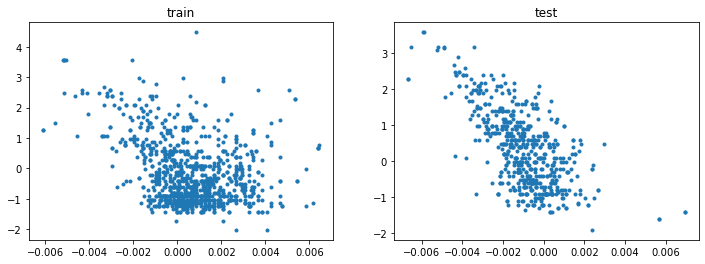

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

axes[0].scatter(X_train, T_train, marker=".")
axes[0].set_title("train")
axes[1].scatter(X_test, T_test, marker=".")
axes[1].set_title("test")
fig.show()

train と test の分布がかなり違う.  
予め shuffle して train と test に分割する必要があるようだ.  
XとTの対応関係を崩さず shuffle する方法は多々あるが、その１つが以下.

In [17]:
import numpy as np

np.random.seed(0) # random　の挙動を固定

p = np.random.permutation(len(X)) # random　な　index のリスト

X = X[p]
T = T[p]

In [18]:
X_train = X[:1000, :]
T_train = T[:1000]
X_test = X[1000:, :]
T_test = T[1000:]

/tmp/ipykernel_406/1532808759.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


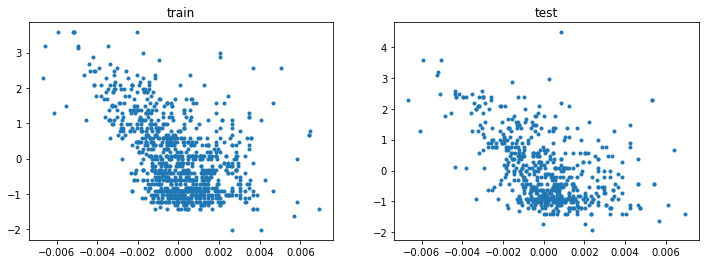

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

axes[0].scatter(X_train, T_train, marker=".")
axes[0].set_title("train")
axes[1].scatter(X_test, T_test, marker=".")
axes[1].set_title("test")
fig.show()

### 5-1-2. モデルの構築

**今回は**, 目的変数 $t$ を以下の回帰関数で予測する.
$$y=ax+b$$
この時、損失が最小になるように, パラメータ$a,b$を定める必要がある. ここでは二乗損失関数を用いる.
$$\mathrm{L}\left(a, b\right)
=\sum^{N}_{n=1}\left(t_n - y_n\right)^2
=\sum^{N}_{n=1}\left(t_n - ax_x-b\right)^2$$

<span style="color: gray; ">※これは, 目的変数 $t$ が上記の回帰関数 $y$ を中心としたガウス分布に従うという仮定を置いて最尤推定することと等価.</span>　

In [86]:
import scipy.optimize as op
import numpy as np
class MyLinearRegression(object):
    def __init__(self):
        """
        Initialize a coefficient and an intercept.
        """
        self.a = 1
        self.b = 1
        
    def fit(self, X, y):
        """
        X: data, array-like, shape (n_samples, n_features)
        y: array, shape (n_samples,)
        Estimate a coefficient and an intercept　from data.
        """
        x=np.reshape(X,(-1,))
        f = lambda params : ((y-params[0]*x-params[1])**2).sum()
        res = op.minimize(f,[self.a,self.b])
        self.a,self.b=res.x;
        # print(res)
        # print(self.a,self.b)
        return self
    
    def predict(self, X):
        """
        Calc y from X
        """
        y=self.a*X+self.b
        return y

上記の単回帰のクラスを完成させ, 以下の実行によって図の回帰直線が得られるはずだ.

係数:  -283.39928081984044
切片:  -0.015532234777218767


/tmp/ipykernel_406/217020868.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


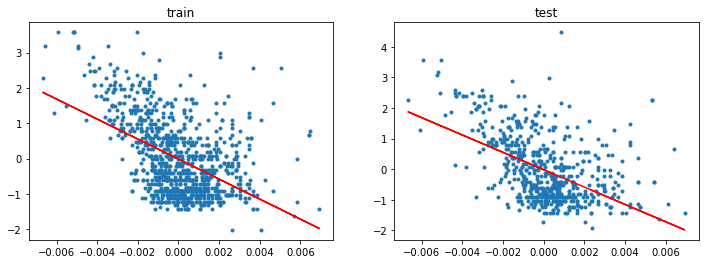

In [87]:
clf = MyLinearRegression()
clf.fit(X_train, T_train)

# 回帰係数
print("係数: ", clf.a)
# 切片
print("切片: ", clf.b)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

axes[0].scatter(X_train, T_train, marker=".")
axes[0].plot(X_train, clf.predict(X_train), color="red")
axes[0].set_title("train")

axes[1].scatter(X_test, T_test, marker=".")
axes[1].plot(X_test, clf.predict(X_test), color="red")
axes[1].set_title("test")
fig.show()

もしdatasetをshuffleせずに上記の学習を行った時, 得られる回帰直線はどうなるだろう？  
試してみてください.

## 5-2. scikit-learnについて
### 5-2-1. モジュールの概要
[scikit-learn](http://scikit-learn.org/stable/)のホームページに詳しい情報がある． 

実は scikit-learn に線形回帰のモジュールがすでにある.  

#### scikit-learn の特徴
- scikit-learn(sklearn)には，多くの機械学習アルゴリズムが入っており，統一した形式で書かれているため利用しやすい．
- 各手法をコードで理解するだけでなく，その元となる論文も紹介されている．
- チュートリアルやどのように利用するのかをまとめたページもあり，似た手法が列挙されている．

In [95]:
import sklearn
print(sklearn.__version__)

0.24.2


係数:  [-288.60241658]
切片:  0.03280215630403101
決定係数:  0.24728357072544427


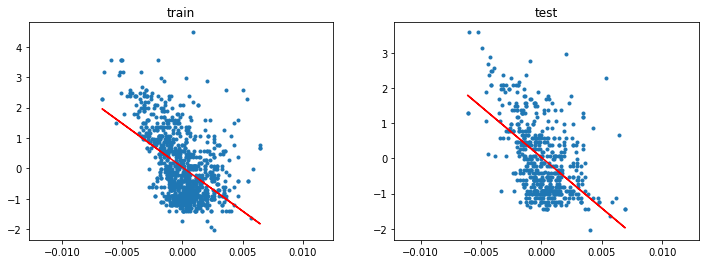

In [162]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()

# 予測モデルを作成
clf.fit(X_train, T_train)
 
# 回帰係数
print("係数: ", clf.coef_)
 
# 切片
print("切片: ", clf.intercept_)
 
# 決定係数
print("決定係数: ", clf.score(X_train, T_train))

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

axes[0].scatter(X_train, T_train, marker=".")
axes[0].plot(X_train, clf.predict(X_train), color="red")
axes[0].set_title("train")

axes[1].scatter(X_test, T_test, marker=".")
axes[1].plot(X_test, clf.predict(X_test), color="red")
axes[1].set_title("test")
fig.show()

自分のコードと同じ結果が出ただろうか？  
また, データを shuffle せず得られた回帰直線のスコアと, shuffleした時の回帰直線のスコアの比較もしてみよう.

scikit-learn の linear regression のコードは [github][1] で公開されている.  
コーディングの参考になると思うので眺めてみるといいだろう.  

### 5-2-2. 回帰モデルの評価  
性能を測るといっても，その目的によって指標を変える必要がある.   
どのような問題で，どのような指標を用いることが一般的か？という問いに対しては，先行研究を確認することを勧める．  
また，指標それぞれの特性(数学的な意味)を知っていることもその役に立つだろう．
[参考][2]  

回帰モデルの評価に用いられる指標は一般にMAE, MSE, 決定係数などが存在する.

1. MAE
2. MSE
3. 決定係数

scikit-learn はこれらの計算をするモジュールも用意されている.

[1]:https://github.com/scikit-learn/scikit-learn/blob/1495f69242646d239d89a5713982946b8ffcf9d9/sklearn/linear_model/base.py#L367
[2]:https://scikit-learn.org/stable/modules/model_evaluation.html

In [165]:
from sklearn import metrics

T_pred = clf.predict(X_test)
print("MAE: ", metrics.mean_absolute_error(T_test, T_pred))
print("MSE: ", metrics.mean_squared_error(T_test, T_pred))
print("決定係数: ", metrics.r2_score(T_test, T_pred))

MAE:  0.7218845932275127
MSE:  0.7810900781645986
決定係数:  0.23604463330510206


### 5-2-3. scikit-learn の他モデルを使ってみよう

In [166]:
# 1. データセットを用意する
from sklearn import datasets
iris = datasets.load_iris() # ここではIrisデータセットを読み込む
print(iris.data[0], iris.target[0]) # 1番目のサンプルのデータとラベル

[5.1 3.5 1.4 0.2] 0


In [167]:
# 2.学習用データとテスト用データに分割する
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target)

# 3. 線形SVMという手法を用いて分類する
from sklearn.svm import SVC, LinearSVC
clf = LinearSVC()
clf.fit(X_train, y_train) # 学習

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [168]:
# 4. 分類器の性能を測る
y_pred = clf.predict(X_test) # 予測
print(metrics.classification_report(y_true=y_test, y_pred=y_pred)) # 予測結果の評価

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.92      0.96        12
           2       0.94      1.00      0.97        16

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.98        38
weighted avg       0.98      0.97      0.97        38



### 5-2-4. 分類モデルの評価

分類問題に対する指標について考えてみよう．一般的な指標だけでも以下の4つがある．
1. 正解率(accuracy)
2. 精度(precision)
3. 再現率(recall)
4. F値(F1-score)

（精度，再現率，F値にはmacro, micro, weightedなどがある）

今回の実験でのそれぞれの値を見てみよう．

In [169]:
print('accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('precision:', metrics.precision_score(y_test, y_pred, average='macro'))
print('recall:   ', metrics.recall_score(y_test, y_pred, average='macro'))
print('F1 score: ', metrics.f1_score(y_test, y_pred, average='macro'))

accuracy:  0.9736842105263158
precision: 0.9803921568627452
recall:    0.9722222222222222
F1 score:  0.9754062362758015


## 5-3. 問題に合わせたコーディング

### 5-3-1. Irisデータの可視化
Irisデータは4次元だったので，直接可視化することはできない．  
4次元のデータをPCAによって圧縮して，2次元にし可視化する．

In [170]:
from sklearn.decomposition import PCA
from sklearn import datasets
iris = datasets.load_iris()

pca = PCA(n_components=2)
X, y = iris.data, iris.target
X_pca = pca.fit_transform(X) # 次元圧縮
print(X_pca.shape)

(150, 2)


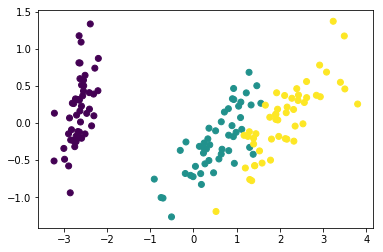

In [171]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y);

In [172]:
# 次元圧縮したデータを用いて分類してみる
X_train, X_test, y_train, y_test = train_test_split(X_pca, iris.target)
clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred2 = clf.predict(X_test)

In [66]:
from sklearn import metrics
print(metrics.classification_report(y_true=y_test, y_pred=y_pred2)) # 予測結果の評価

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.87      0.93        15
           2       0.88      1.00      0.93        14

    accuracy                           0.95        38
   macro avg       0.96      0.96      0.95        38
weighted avg       0.95      0.95      0.95        38



### 5-3-2. テキストに対する処理

#### テキストから特徴量を設計
テキストのカウントベクトルを作成し，TF-IDFを用いて特徴ベクトルを作る．  
いくつかの設計ができるが，例題としてこの手法を用いる．

ここでは，20newsgroupsというデータセットを利用する．

In [67]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med']

news_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

In [68]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(news_train.data)

In [69]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)

#### Naive Bayseによる学習

In [70]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tf, news_train.target)

In [71]:
docs = ["God is love.", "I study about Computer Science."]
X_test_counts = count_vec.transform(docs)
X_test_tf = tf_transformer.transform(X_test_counts)
preds = clf.predict(X_test_tf)
for d, label_id in zip(docs, preds):
    print("{} -> {}".format(d, news_train.target_names[label_id]))

God is love. -> soc.religion.christian
I study about Computer Science. -> sci.med


このように文に対して，categoriesのうちのどれに対応するかを出力する学習器を作ることができた．  
この技術を応用することで，ある文がポジティブかネガティブか，スパムか否かなど自然言語の文に対する分類問題を解くことができる．  

### 5-3-3. Pipelineによる結合

In [72]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('countvec', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

text_clf.fit(news_train.data, news_train.target)

Pipeline(memory=None,
         steps=[('countvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [73]:
for d, label_id in zip(docs, text_clf.predict(docs)):
    print("{} -> {}".format(d, news_train.target_names[label_id]))

God is love. -> soc.religion.christian
I study about Computer Science. -> sci.med


## 5.4 scikit-learn 準拠コーディング

scikit-learn　準拠でコーディングするメリットは多数存在する.
1. scikit-learn の用意するgrid search や cross validation を使える.
2. 既存のscikit-learn の他手法と入れ替えが容易になる.
3. 他の人にみてもらいやすい。使ってもらいやすい.  
4. <span style="color: gray; ">本家のコミッターになれるかも？</span>

詳しくは　[Developer’s Guide][1]　に書いてある.

[1]:https://scikit-learn.org/stable/developers/#rolling-your-own-estimator

scikit-learn ではモデルは以下の4つのタイプに分類されている.

- Classifer
    - Naive Bayes Classifer などの分類モデル
- Clusterring
    - K-mearns 等のクラスタリングモデル
- Regressor
    - Lasso, Ridge などの回帰モデル
- Transformer
    - PCA などの変数の変換モデル

***準拠コーディングでやるべきことは、***

- sklearn.base.BaseEstimatorを継承する
- 上記タイプに応じたMixinを多重継承する  

(予測モデルの場合)
- fitメソッドを実装する
    - initでパラメータをいじる操作を入れるとgrid searchが動かなくなる（後述）
- predictメソッドを実装する
    
### 5-4-1.　リッジ回帰のscikit-learn 準拠コーディング

試しに今までにコーディングした MyLinearRegression を改造し, scikit-learn 準拠にコーディングし直してみよう.  
ついでにリッジ回帰の選択ができるようにもしてみよう.

In [36]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array

回帰なので BaseEstimator と RegressorMixin の継承をする.  
さらにリッジ回帰のオプションも追加するため, initにハイパーパラメータも追加する.  
入力のshapeやdtypeを整えるために```check_X_y```や```check_array```を用いる(推奨).

In [ ]:
class MyLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, lam = 0):
        """
        Initialize a coefficient and an intercept.
        """
        self.a = 
        self.b = 
        self.lam = lam
        
    def fit(self, X, y):
        """
        X: array-like, shape (n_samples, n_features)
        y: array, shape (n_samples,)
        Estimate a coefficient and an intercept　from data.
        """
        X, y = check_X_y(X, y, y_numeric=True)
        if self.lam != 0:
            pass
        else:
            pass
        
        self.a_ = 
        self.b_ = 
        return self
    
    def predict(self, X):
        """
        Calc y from X
        """
        check_is_fitted(self, "a_", "b_") # 学習済みかチェックする(推奨)
        X = check_array(X)
        return y

***制約***

- initで宣言する変数に全て初期値を定める
- また引数の変数名とクラス内の変数名は一致させる
- initにデータは与えない。データの加工なども(必要なら)fit内で行う
- データから推定された値はアンダースコアをつけて区別する. 今回なら、a_と b_をfit関数内で新しく定義する.
- アンダースコアで終わる変数をinit内では宣言しないこと.
- init内で引数の確認, 加工をしてはいけない. 例えば```self.lam=2*lam```などをするとgrid searchができなくなる. [参考][1]

> As model_selection.GridSearchCV uses set_params to apply parameter setting to estimators, it is essential that calling set_params has the same effect as setting parameters using the __init__ method. The easiest and recommended way to accomplish this is to not do any parameter validation in __init__. All logic behind estimator parameters, like translating string arguments into functions, should be done in fit.

[github][2]のコードをお手本にしてみるのもいいだろう.

[1]:https://scikit-learn.org/stable/developers/contributing.html#coding-guidelines
[2]:https://github.com/scikit-learn/scikit-learn/blob/1495f69242646d239d89a5713982946b8ffcf9d9/sklearn/linear_model/base.py#L367

### 5-4-2. scikit-learn 準拠かどうか確認

自作のコードがちゃんとscikit-learn準拠かどうか確かめるには以下を実行する.

In [ ]:
from sklearn.utils.estimator_checks import check_estimator
check_estimator(MyLinearRegression)

問題があれば指摘してくれるはずだ. なお上記を必ずパスする必要はない.  

#### Grid Search
準拠モデルを作ったなら, ハイパーパラメータの決定をscikit-learnでやってみよう.

決定係数:  0.24638055627114677
lam:  1.670170079024566e-05


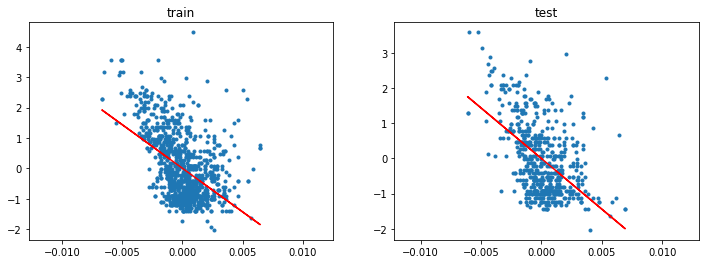

In [59]:
import numpy as np
from sklearn.model_selection import GridSearchCV

np.random.seed(0)

# Grid search
parameters = {'lam':np.exp([i for i in range(-30,1)])}
reg = GridSearchCV(MyLinearRegression(),parameters,cv=5)
reg.fit(X_train,T_train)
best = reg.best_estimator_

# 決定係数
print("決定係数: ", best.score(X_train, T_train)) # BaseEstimatorを継承しているため使える
# lambda
print("lam: ", best.lam)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

axes[0].scatter(X_train, T_train, marker=".")
axes[0].plot(X_train, best.predict(X_train), color="red")
axes[0].set_title("train")

axes[1].scatter(X_test, T_test, marker=".")
axes[1].plot(X_test, best.predict(X_test), color="red")
axes[1].set_title("test")
fig.show()

## [練習問題](./../exercise/questions.md#chapter-5)